In [27]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import pacmap
from preload import *
from annoy import AnnoyIndex

In [3]:
tree=[]
with open('./tree.txt','r')as f:
    f.readline()
    for line in f.readlines():
        tmp=line.strip().split(',')
        tree.append((tmp[0],tmp[3]))

In [4]:
import networkx as nx
T=nx.DiGraph()
T.add_edges_from(tree)

In [5]:
Class = ['「未归类」话题','学科','实体','「形而上」话题','产业','生活、艺术、文化与活动']

In [6]:
M={}
n=0
for i in T:
    n+=1
    tmp = []
    M[i]=[]
    for c in Class:
        path=[]
        try:
            path = nx.shortest_path(T,i,c)
        except:
            pass
        if path:
            M[i].append(path)

In [7]:
for i in M:
    if M[i]==[]:
        break

In [8]:

import pylab as mpl     #import matplotlib as mpl
 
#设置汉字格式
# sans-serif就是无衬线字体，是一种通用字体族。
# 常见的无衬线字体有 Trebuchet MS, Tahoma, Verdana, Arial, Helvetica,SimHei 中文的幼圆、隶书等等
mpl.rcParams['font.sans-serif'] = ['Heiti TC']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False 


In [9]:
data = pd.read_json('./ProcessingData_pd.json')

In [11]:
from collections import defaultdict

In [10]:
D = defaultdict(lambda :0)
A = defaultdict(lambda :[])
B = defaultdict(lambda :[])
C = defaultdict(lambda :[])
for tmp,a,b,c in zip(data.topic,data.answer_num,data.follower_num,data.lasting_days):
    if tmp:
        for t in tmp:
            A[t].append(a)
            B[t].append(b)
            C[t].append(c)
        if len(tmp)==1:
            D[(tmp[0],tmp[0])]+=1
        else:
            tmp =sorted(tmp)
            for i in range(len(tmp)):
                for j in range(i+1,len(tmp)):
                    D[(tmp[i],tmp[j])]+=1/len(tmp)
                    

In [12]:
G = nx.Graph()
for a,b in D:
    G.add_edge(a,b,weight=D[(a,b)])

In [13]:
d = G.degree()

In [14]:
nodes = [i for i in G if d[i]>=70]
'「未归类」话题'in nodes,len(nodes)

(True, 4117)

In [15]:
import  gensim
from sklearn.manifold import TSNE

In [16]:
train_data = [i for i in data.topic if len(i)>=2]

In [21]:
size=20
negative=5
workers=12
model = gensim.models.word2vec.Word2Vec(sentences=train_data, 
                                    vector_size=size,
                                      workers=workers,
                                      negative=negative,
                                      min_count=1,
                                        compute_loss=True,
                                        epochs=10,sg=0,window=20,
                                        seed=1)



In [22]:
model.corpus_count

312087

In [23]:
model.get_latest_training_loss()

1276946.75

In [307]:
#model.train(train_data, epochs=10,total_examples=model.corpus_count)

In [24]:
X=[]
for a in model.wv.vectors:
    X.append(list(a))
X=np.array(X)

In [28]:
n, dim = X.shape
n_neighbors = 5
metric = 'euclidean'
tree = AnnoyIndex(dim, metric=metric)
for i in range(n):
    tree.add_item(i, X[i, :])
 
tn=10
tree.build(tn)
nbrs = np.zeros((n, tn), dtype=np.int32)
for i in range(n):
    nbrs_ = tree.get_nns_by_item(i, tn + 1) # The first nbr is always the point itself
    nbrs[i, :] = nbrs_[1:]
scaled_dist = np.ones((n, n_neighbors)) # No scaling is needed

# Type casting is needed for numba acceleration
X = X.astype(np.float32)
scaled_dist = scaled_dist.astype(np.float32)


# make sure n_neighbors is the same number you want when fitting the data
pair_neighbors = pacmap.sample_neighbors_pair(X, scaled_dist, nbrs, np.int32(n_neighbors))


# initializing the pacmap instance
# feed the pair_neighbors into the instance

In [33]:
# fit the data (The index of transformed data corresponds to the index of the original data)
embedding = pacmap.PaCMAP(2, n_neighbors=n_neighbors,
                          MN_ratio=0.5, FP_ratio=2.0, pair_neighbors=pair_neighbors) 
X_transformed = embedding.fit_transform(X, init="pca")
X_embedded= X_transformed

In [38]:
pp=30
X_embedded = TSNE(n_components=2,n_jobs=15,metric='cosine',perplexity=pp).fit_transform(X)
fun_save_pickle([X_embedded,model.wv.index2word],'map_tsne_perplexity_%d.pickle'%pp)

[ok] Loading map_tsne_perplexity_30.pickle
==Time: 0.02, Memory used: 0.00 GB, Current Memory: 1.104019 GB==


([], [])

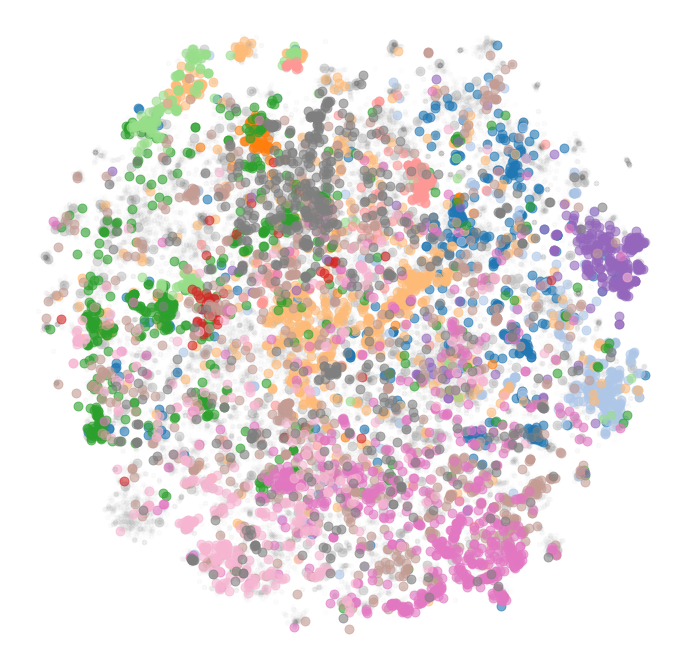

In [36]:
[X_embedded,index2word]=fun_load_pickle('map_tsne_perplexity_%d.pickle'%pp)


M1 = {}
for i,a in zip(index2word,X_embedded):
    if i in M and len(M[i])==1:
        c = M[i][0][-1]
        if c in ['生活、艺术、文化与活动'] and len(M[i][0])>=3:
            c = M[i][0][-2] 
        if c not in M1:
            M1[c]=[]
        M1[c].append([a[0],a[1]])

a = [[i,len(M1[i])] for i in M1 if len(M1[i])>=55]



plt.figure(figsize=(12,12))
colors = plt.cm.tab20.colors
n=0
plt.scatter(X_embedded[:,0],X_embedded[:,1],color='gray',alpha=.01,s=20)
for i,_ in a:
    if i not in ['实体','「未归类」话题','「形而上」话题','学科','产业']:
        tmp = np.array(M1[i])
        plt.scatter(tmp[:,0],tmp[:,1],s=80,fc=colors[n],alpha=.6,label=i,ec=colors[n])
        n+=1
n+=2
for i in ['实体','学科','产业','「形而上」话题',]:
        tmp = np.array(M1[i])
        plt.scatter(tmp[:,0],tmp[:,1],s=80,fc=colors[n],alpha=.6,label=i,ec=colors[n])
        n+=1
for i in ['「未归类」话题']:
    tmp = np.array(M1[i])
    plt.scatter(tmp[:,0],tmp[:,1],s=80,fc=colors[n],alpha=.6,label=i,ec=colors[n],zorder=-1)
    n+=1
#plt.legend(frameon=False,fontsize=15,loc=3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])  
# plt.savefig('./网络1.png', bbox_inches ='tight')